<a href="https://colab.research.google.com/github/Vineetha-2309/AI-Poem-Generator/blob/main/AI_Poem_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

# Dataset
poems = [
    "roses are red",
    "violets are blue",
    "sugar is sweet",
    "and so are you",
    "the sun is shining",
    "the birds are singing",
    "love is a flame",
    "burning in time",
    "the stars are bright",
    "throughout the night",
    "a gentle breeze blows",
    "as the moonlight glows",
    "words unspoken",
    "hearts never broken",
    "dreams that fly",
    "under the sky",
    "the flowers bloom",
    "erasing the gloom",
    "hope is alive",
    "we rise and thrive"
]

# Preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(poems)
total_words = len(tokenizer.word_index) + 1

# Create input sequences
input_sequences = []
for line in poems:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        seq = token_list[:i+1]
        input_sequences.append(seq)

# Padding sequences
max_seq_len = max(len(x) for x in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# Split data
xs = input_sequences[:, :-1]
ys = tf.keras.utils.to_categorical(input_sequences[:, -1], num_classes=total_words)

# Model definition
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_seq_len-1))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(xs, ys, epochs=300, verbose=0)

# Text generation with temperature sampling
def generate_poem(seed_text, next_words=10, temperature=1.0):
    result = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([result])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]
        # Apply temperature
        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        predicted_index = np.random.choice(range(len(predictions)), p=predictions)

        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        result += " " + output_word
    return result

# Test it
seed = "the sky"
print("Generated Poem:")
print(generate_poem(seed, next_words=10, temperature=0.8))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Generated Poem:
the sky is shining flame flame glows glows bright singing you thrive


Columns in dataset: Index(['Unnamed: 0', 'Title', 'Poem', 'Poet', 'Tags'], dtype='object')
✔️ Loaded 2000 clean lines of poetry.
✔️ Created 12104 input sequences.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.0615 - loss: 7.4159
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0665 - loss: 6.6658
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0722 - loss: 6.5354
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.0797 - loss: 6.3868
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0851 - loss: 6.2606
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.0881 - loss: 6.1288
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0841 - loss: 6.0565
Epoch 8/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0885 - loss: 5.9606
Epoch 9/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0930 - loss: 5.8921
Epoch 10/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.0946 - loss: 5.8095

🌙 Generated Poem:

the moon practicing a man
fingers his tail of by
was their to through vitreous
the lovers buck species turbulence
othe

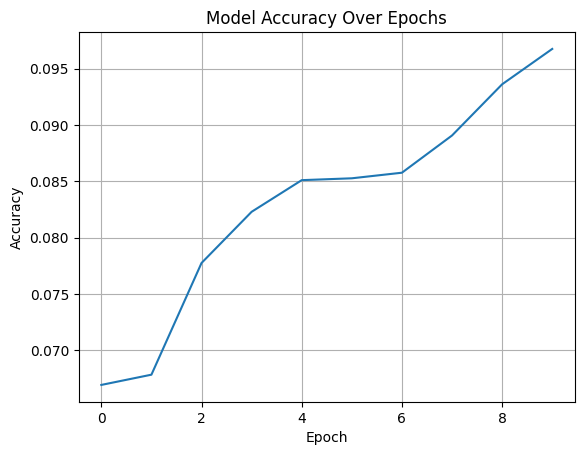

In [1]:
!pip install tensorflow pandas matplotlib --quiet

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import re
import gc  # for garbage collection

# Upload CSV file
from google.colab import files
uploaded = files.upload()

# Load and validate dataset
df = pd.read_csv('poetryfoundation_data.csv')
print("Columns in dataset:", df.columns)

if 'Poem' in df.columns:
    df = df.dropna(subset=['Poem'])
    poems = df['Poem']
else:
    raise ValueError("Column 'Poem' not found in dataset. Please check the column name.")

# Clean and collect poetic lines
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s']", '', text)
    text = re.sub(r'\n+', ' ', text)
    return text

corpus = []
for poem in poems:
    for line in poem.split('\n'):
        line = clean_text(line.strip())
        if 3 < len(line.split()) <= 15:
            corpus.append(line)
        if len(corpus) >= 2000:
            break
    if len(corpus) >= 2000:
        break

print(f"✔️ Loaded {len(corpus)} clean lines of poetry.")

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# Input sequences
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    if len(token_list) < 2:
        continue
    for i in range(1, len(token_list)):
        input_sequences.append(token_list[:i+1])

print(f"✔️ Created {len(input_sequences)} input sequences.")

# Padding sequences
max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# Features & Labels
xs = input_sequences[:, :-1]
ys = tf.keras.utils.to_categorical(input_sequences[:, -1], num_classes=total_words)

# Clear unnecessary memory
del input_sequences
gc.collect()

# Build a smaller model
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_seq_len-1))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train (reduce batch size)
history = model.fit(xs, ys, epochs=10, batch_size=32, verbose=1)

# Poem Generator with line breaks
def generate_poem(seed_text, next_words=30, temperature=0.8, words_per_line=5):
    generated = seed_text
    poem_lines = []
    current_line = seed_text

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated])[0]
        if len(token_list) == 0:
            break
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]

        # Temperature sampling
        predictions = np.log(predictions + 1e-9) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        predicted_index = np.random.choice(len(predictions), p=predictions)

        # Decode word
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        if output_word == '':
            break

        current_line += ' ' + output_word
        generated += ' ' + output_word

        if len(current_line.split()) >= words_per_line:
            poem_lines.append(current_line.strip())
            current_line = ''

    if current_line:
        poem_lines.append(current_line.strip())

    return "\n".join(poem_lines)

# Test Poem Generation
print("\n🌙 Generated Poem:\n")
print(generate_poem("the moon", next_words=30, temperature=0.8, words_per_line=5))

# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [2]:
print("🌿 Poem: The Forest")
print(generate_poem("the forest", next_words=30, temperature=0.8, words_per_line=5))


🌿 Poem: The Forest
the forest minutes any was
hand again out to tops
teacher or i stop quirky
you if i was far
up here a canoe's sky
she hoarfrost their witch in
it write


In [3]:
print("🌙 Poem: The Moon")
print(generate_poem("the moon", next_words=30, temperature=0.7, words_per_line=4))


🌙 Poem: The Moon
the moon moon that
wind and the fathers
smile stopped to the
bootrims right merged to
the new tongue better
dells civic gift roses
gasoline abstruse some green
strong drilled stroke were


In [4]:
print("💖 Poem: Her Eyes")
print(generate_poem("her eyes", next_words=35, temperature=0.9, words_per_line=6))


💖 Poem: Her Eyes
her eyes and the opportunities one
light of the old according of
your talk sniffy neck wardrobe amniotic
threatened the have sex and sing
in make live to cant that
huddling 10 crazed clinging like an
twitching


In [5]:
print("✨ Poem: Rise Again")
print(generate_poem("rise again", next_words=25, temperature=0.85, words_per_line=5))


✨ Poem: Rise Again
rise again the rich of
a stick over omnipresence glory
the rings parents listening among
lapping ready the gift pike
that she prince tubular rip
the rectangle
